In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.io as sio
import h5py
import scipy.signal as scisig
import importlib
import analysis_utils as au
import cmath

In [2]:
filename = r'D:\Lab Data\lorentz_force\sphere20250604\20250609\1 V\pos0 10\tt0.hdf5'
data, attrs = au.load_data_lf(filename)
PSD = scisig.welch(data['channel_d'][:10**7], fs = 1/attrs['delta_t'], nperseg = int(1/attrs['delta_t']))
fft = np.fft.fft(data['channel_d'][:10**5])

In [3]:
cal = 10**(-15)*0.75 # Matching to Yu-Han's calibration
print(np.sqrt(PSD[1][5500]*cal)/np.abs(fft[5500]))
cal2 = np.sqrt(PSD[1][5500]*cal)/np.abs(fft[5500])
print(np.abs(fft[5500]) * cal2)

2.6787302651686203e-14
4.706690655691461e-13


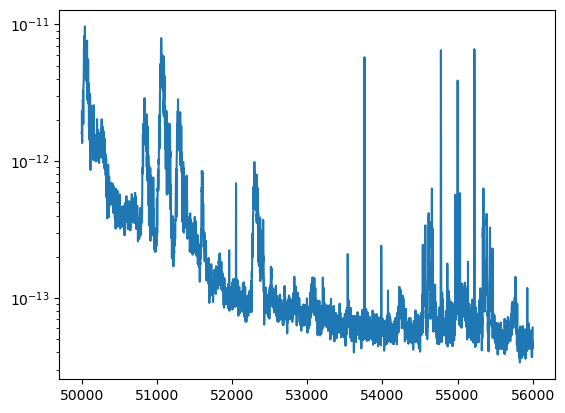

In [4]:
lb = 50000
ub = 56000
plt.plot(PSD[0][lb:ub], np.sqrt(PSD[1][lb:ub]*cal))
#plt.plot(PSD[0][lb:ub], np.abs(fft[lb:ub])*cal2)
plt.yscale('log')

In [5]:
freqs = [5500]
numfiles = 10
int_n = 10**5
file_n = 10**7
samples_per_file = int(file_n/int_n)
positions = [0, 1, 2]
cycles = np.linspace(0, 9, 10, dtype = int)
directions = [1, 2]

phases_pos = np.zeros((len(cycles), len(directions), len(positions), len(freqs), int(numfiles*samples_per_file)))
amps_pos = np.zeros((len(cycles), len(directions), len(positions), len(freqs), int(numfiles*samples_per_file)))
cfs_pos = np.zeros((len(cycles), len(directions), len(positions), len(freqs), int(numfiles*samples_per_file)))
lockin_pos = np.zeros((len(cycles), len(directions), len(positions), int(numfiles*samples_per_file)))

for cycle in cycles:
    for direction in directions:
        for position in positions:
            path = r'D:\Lab Data\lorentz_force\sphere20250604\20250609\1 V\pos'+str(position)+' '+str(direction)+str(cycle)+r'\tt'
            files = np.linspace(0, numfiles-1, numfiles, dtype = int)
            end = '.hdf5'
            phases2 = np.zeros((len(freqs), int(numfiles*samples_per_file)))
            amps2 = np.zeros((len(freqs), int(numfiles*samples_per_file)))
            cf2 = np.zeros((len(freqs), int(numfiles*samples_per_file)))
            li2 = np.zeros((int(numfiles*samples_per_file)))
            for n, file in enumerate(files):
                filename = path + str(file) + end
                data, attrs = au.load_data_lf(filename)
                for i in range(samples_per_file):
                    drive = data['channel_f'][i*int_n:(i+1)*int_n]
                    drive2 = data['channel_d'][i*int_n:(i+1)*int_n]
                    lockin = data['channel_g'][i*int_n:(i+1)*int_n]
                    fft_drive = np.fft.rfft(drive)
                    fft_drive2 = np.fft.rfft(drive2)
                    for m, freq in enumerate(freqs):
                        phase = np.unwrap([-np.pi, cmath.phase(fft_drive[freq])-cmath.phase(fft_drive2[freq])])
                        amp = np.abs(fft_drive2[freq])/np.abs(fft_drive[freq])
                        cf = np.argmax(np.abs(fft_drive2[4800:5200]))*10+48000
                        li = np.mean(lockin)
                        amps2[m, samples_per_file*n+i] = amp
                        phases2[m, samples_per_file*n+i] = phase[1]
                        cf2[m, samples_per_file*n+i] = cf
                        li2[samples_per_file*n+i] = li
            phases_pos[cycle, direction-1, position] = phases2
            amps_pos[cycle, direction-1, position] = amps2
            cfs_pos[cycle, direction-1, position] = cf2
            lockin_pos[cycle, direction-1, position] = li2

In [17]:
data_dict = {'amps': amps_pos, 'phases': phases_pos, 'cfs': cfs_pos, 'lockin': lockin_pos}
filename = r'C:\Users\thoma\Documents\SIMPLE\Data\Lab data\Lorentz force\Magsweep250609.hdf5'
au.save_data_hdf5(filename, data_dict)

In [ ]:
filename = r'C:\Users\thoma\Documents\SIMPLE\Data\Lab data\Lorentz force\Magsweep250609.hdf5'
data = au.load_data_hdf52(filename)
amps_pos = data['amps']
phases_pos = data['phases']
cfs_pos = data['cfs']

In [8]:
cal = 10**(-15)*0.75 # Matching to Yu-Han's calibration
cal3 = 3.1825020700030454e-10
print(amps_pos[0,0,0,0,0]*cal3)

1.768413409632643e-12


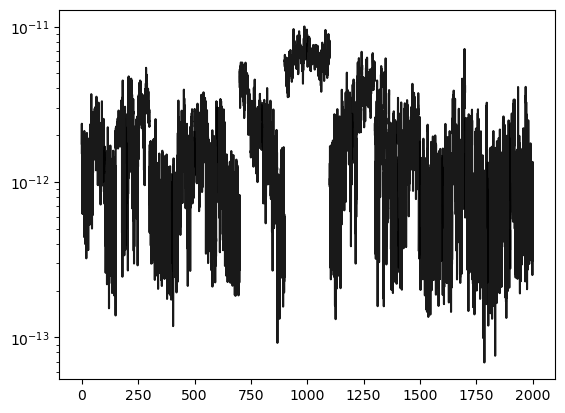

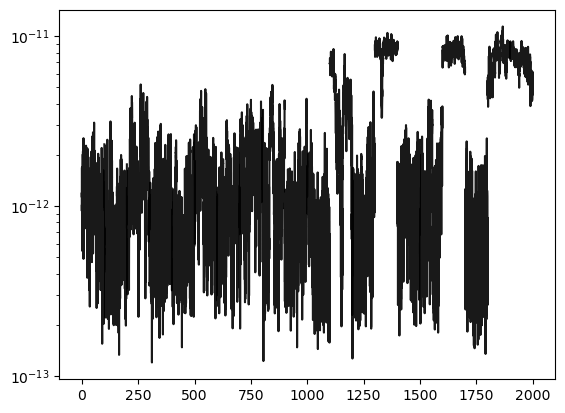

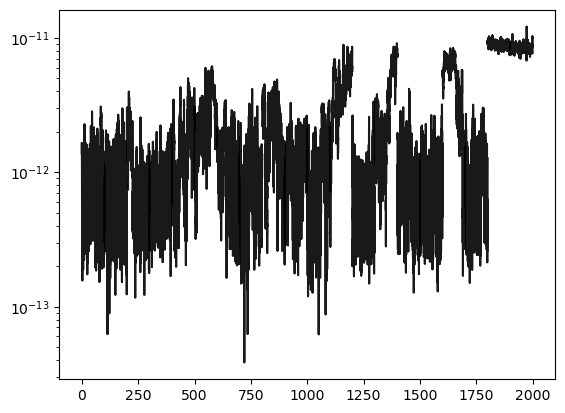

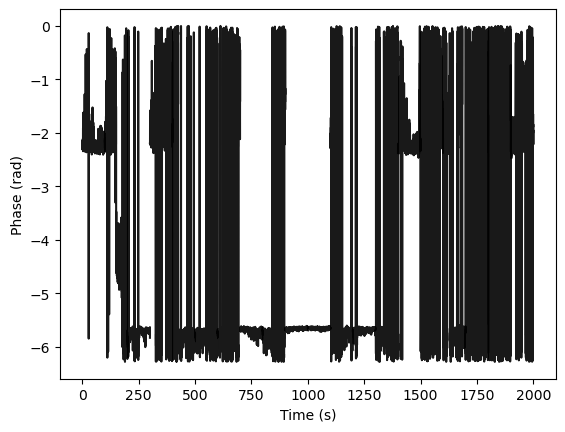

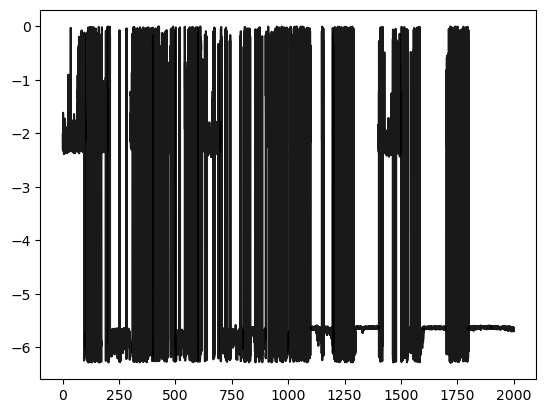

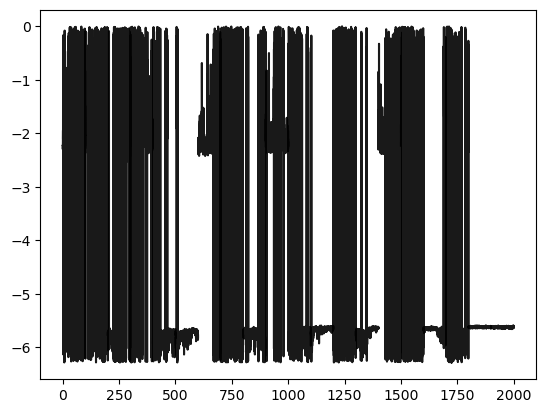

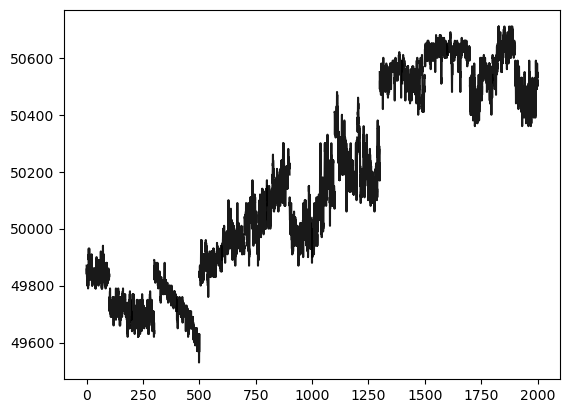

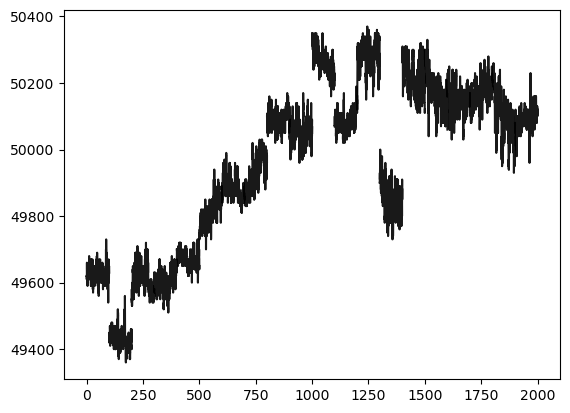

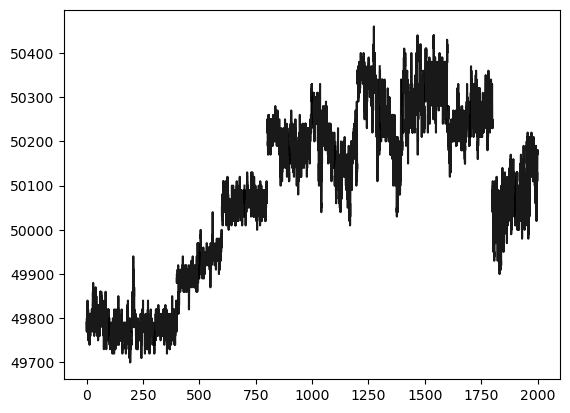

In [9]:
for m, i in enumerate(amps_pos[:,:, 0, 0].reshape((20, 1000))[:]):
    plt.plot(np.linspace(0, 99.9, 1000)+100*m, i*cal3, 'k', alpha = 0.9)
plt.yscale('log')
plt.figure()
for m, i in enumerate(amps_pos[:,:, 1, 0].reshape((20, 1000))):
    plt.plot(np.linspace(0, 100, 1000)+100*m, i*cal3, 'k', alpha = 0.9)
plt.yscale('log')
plt.figure()
for m, i in enumerate(amps_pos[:,:, 2, 0].reshape((20, 1000))):
    plt.plot(np.linspace(0, 100, 1000)+100*m, i*cal3, 'k', alpha = 0.9)
plt.yscale('log')

plt.figure()
for m, i in enumerate(phases_pos[:,:, 0, 0].reshape((20, 1000)[:])):
    plt.plot(np.linspace(0, 99.9, 1000)+100*m, i, 'k', alpha = 0.9)
plt.ylabel('Phase (rad)')
plt.xlabel('Time (s)')
plt.figure()
for m, i in enumerate(phases_pos[:,:, 1, 0].reshape((20, 1000))):
    plt.plot(np.linspace(0, 100, 1000)+100*m, i, 'k', alpha = 0.9)
plt.figure()
for m, i in enumerate(phases_pos[:,:, 2, 0].reshape((20, 1000))):
    plt.plot(np.linspace(0, 100, 1000)+100*m, i, 'k', alpha = 0.9)

plt.figure()
for m, i in enumerate(cfs_pos[:,:, 0, 0].reshape((20, 1000)[:])):
    plt.plot(np.linspace(0, 99.9, 1000)+100*m, i, 'k', alpha = 0.9)
plt.figure()
for m, i in enumerate(cfs_pos[:,:, 1, 0].reshape((20, 1000))):
    plt.plot(np.linspace(0, 100, 1000)+100*m, i, 'k', alpha = 0.9)
plt.figure()
for m, i in enumerate(cfs_pos[:,:, 2, 0].reshape((20, 1000))):
    plt.plot(np.linspace(0, 100, 1000)+100*m, i, 'k', alpha = 0.9)


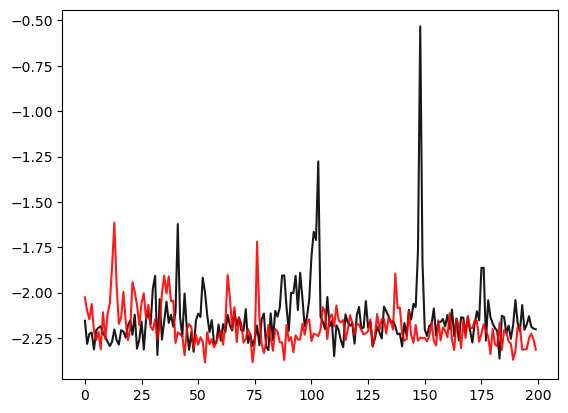

In [87]:
plt.plot(phases_pos[0, 0, 0, 0, :200], 'k', alpha = 0.9)
plt.plot(phases_pos[0, 0, 1, 0, :200], 'r', alpha = 0.9)
#plt.plot(phases_pos[0, 0, 2, 0, :], 'b', alpha = 0.9)

In [89]:
print(np.mean(phases_pos[0, 0, 0, 0, :200]))
print(np.mean(phases_pos[0, 0, 1, 0, :200]))
print(np.std(phases_pos[0, 0, 0, 0, :200])/np.sqrt(200))
print(np.std(phases_pos[0, 0, 1, 0, :200])/np.sqrt(200))

-2.142682198012528
-2.190605248804132
0.0124596696435455
0.00771771313121272


(9e-14, 2e-11)

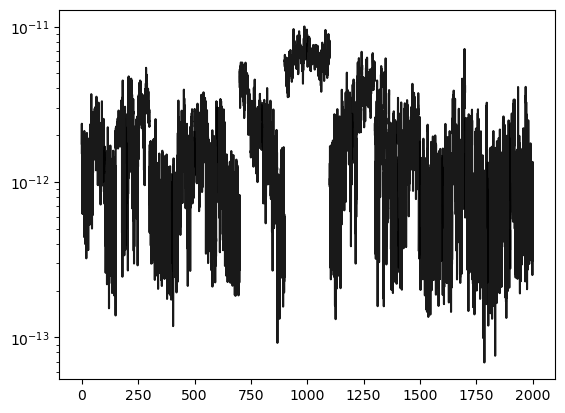

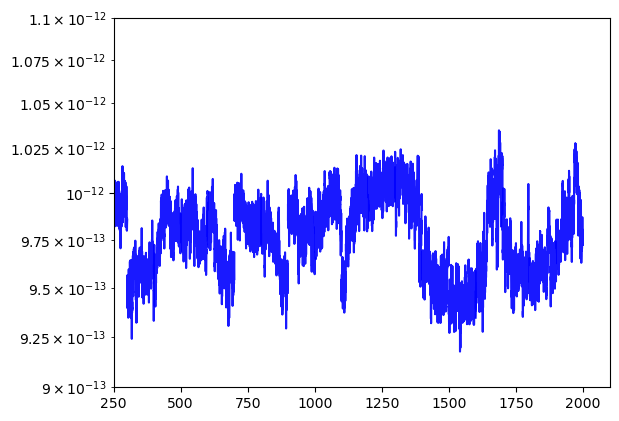

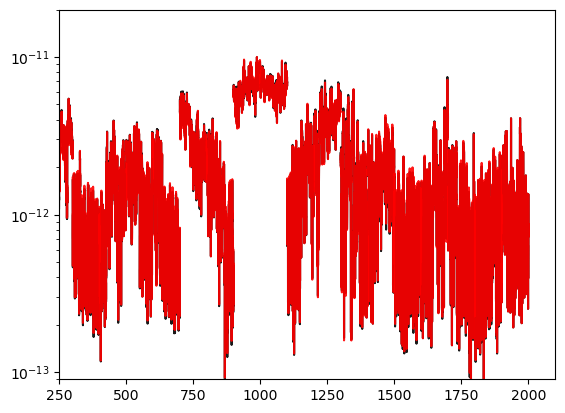

In [60]:
for m, i in enumerate(amps_pos[:,:, 0, 0].reshape((20, 1000))[:]):
    plt.plot(np.linspace(0, 99.9, 1000)+100*m, i*cal3, 'k', alpha = 0.9)
plt.yscale('log')
plt.figure()
for m, i in enumerate(lockin_pos[:, :, 0].reshape((20, 1000))[:]):
    plt.plot(np.linspace(0, 99.9, 1000)+100*m, np.abs(i)*10**(-11), 'b', alpha = 0.9)
plt.yscale('log')
plt.xlim(250)
plt.ylim(9e-13, 1.1e-12)
plt.figure()
for m, i in enumerate(amps_pos[:,:, 0, 0].reshape((20, 1000))[:]*lockin_pos[:, :, 0].reshape((20, 1000))[:]/lockin_pos[:, :, 0].reshape((20, 1000))[-1]):
    plt.plot(np.linspace(0, 99.9, 1000)+100*m, i*cal3, 'k', alpha = 0.9)
for m, i in enumerate(amps_pos[:,:, 0, 0].reshape((20, 1000))[:]):
    plt.plot(np.linspace(0, 99.9, 1000)+100*m, i*cal3, 'r', alpha = 0.9)
plt.yscale('log')
plt.xlim(250)
plt.ylim(9e-14, 2e-11)

In [44]:
print(len(lockin_pos[0][0][0][0]))
print(len(amps_pos[0][0][0][0]))

TypeError: object of type 'numpy.float64' has no len()

In [10]:
cf_rs = cfs_pos[:,:, 0, 0].reshape((20000))
amp_rs = amps_pos[:,:, 0, 0].reshape((20000))

cf_rs2 = cfs_pos[:,:, 1, 0].reshape((20000))
amp_rs2 = amps_pos[:,:, 1, 0].reshape((20000))

cf_rs3 = cfs_pos[:,:, 2, 0].reshape((20000))
amp_rs3 = amps_pos[:,:, 2, 0].reshape((20000))

In [11]:
amp_mean1 = np.mean(cal3*amp_rs)
amp_std1 = np.std(cal3*amp_rs)/np.sqrt(len(amp_rs[:37000]))
print(amp_mean1, amp_std1)

amp_mean12 = np.mean(cal3*amp_rs*np.abs((cf_rs**2 - 55000**2))/np.abs((cf_rs[0]**2 - 55000**2)))
amp_std12 = np.std(cal3*amp_rs*np.abs((cf_rs**2 - 55000**2))/np.abs((cf_rs[0]**2 - 55000**2)))/np.sqrt(len(amp_rs))
print(amp_mean12, amp_std12)

amp_mean2 = np.mean(cal3*amp_rs2[:37000])
amp_std2 = np.std(cal3*amp_rs2[:37000])/np.sqrt(len(amp_rs2[:37000]))
print(amp_mean2, amp_std2)

amp_mean22 = np.mean(cal3*amp_rs2[:37000]*np.abs((cf_rs2[:37000]**2 - 55000**2))/np.abs((cf_rs2[0]**2 - 55000**2)))
amp_std22 = np.std(cal3*amp_rs2[:37000]*np.abs((cf_rs2[:37000]**2 - 55000**2))/np.abs((cf_rs2[0]**2 - 55000**2)))/np.sqrt(len(amp_rs2[:37000]))
print(amp_mean22, amp_std22)

amp_mean3 = np.mean(cal3*amp_rs3[:37000])
amp_std3 = np.std(cal3*amp_rs3[:37000])/np.sqrt(len(amp_rs3[:37000]))
print(amp_mean3, amp_std3)

amp_mean32 = np.mean(cal3*amp_rs3[:37000]*np.abs((cf_rs3[:37000]**2 - 55000**2))/np.abs((cf_rs3[0]**2 - 55000**2)))
amp_std32 = np.std(cal3*amp_rs3[:37000]*np.abs((cf_rs3[:37000]**2 - 55000**2))/np.abs((cf_rs3[0]**2 - 55000**2)))/np.sqrt(len(amp_rs3[:37000]))
print(amp_mean32, amp_std32)

2.060286789882731e-12 1.3049199918287079e-14
1.9686563058384254e-12 1.264201656192282e-14
2.629036383016569e-12 1.998270310028672e-14
2.4507259030152026e-12 1.847638163176314e-14
2.410119205968013e-12 1.861919530118175e-14
2.273445168218039e-12 1.7539398709951595e-14


Text(0, 0.5, 'Amplitude (m/$\\sqrt{Hz}$)')

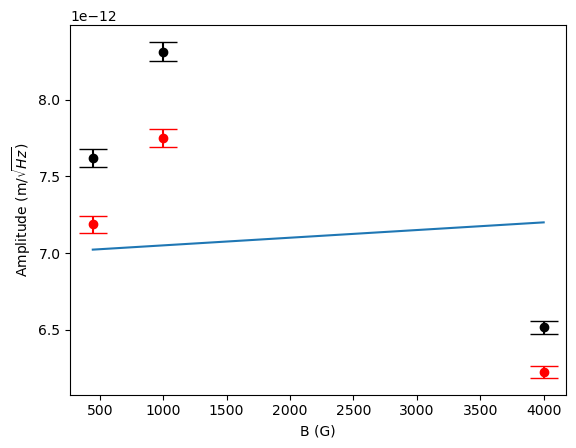

In [13]:
B = 4000*np.array([1, (8/16)**2, (8/24)**2])
B2 = 4000*np.linspace(1, (8/24)**2, 1000)

m1 = np.array([amp_mean1, amp_mean2, amp_mean3])
s1 = np.array([amp_std1, amp_std2, amp_std3])

m2 = np.array([amp_mean12, amp_mean22, amp_mean32])
s2 = np.array([amp_std12, amp_std22, amp_std32])

plt.errorbar(B, m1*np.sqrt(10), yerr = s1*np.sqrt(10), color = 'k', marker = 'o', linestyle = 'None', capsize = 10, label = 'Uncorrected')
plt.errorbar(B, m2*np.sqrt(10), yerr = s2*np.sqrt(10), color = 'r', marker = 'o', linestyle = 'None', capsize = 10, label = 'Corrected')
plt.plot(B2, 0.7*10**(-11)+B2*1*10**(-14)/200)
plt.xlabel('B (G)')
plt.ylabel('Amplitude (m/$\sqrt{Hz}$)')


In [219]:
lb = 0
ub = 5000

amp_mean1 = np.mean(cal3*amp_rs[lb:ub])
amp_std1 = np.std(cal3*amp_rs[lb:ub])/np.sqrt(len(amp_rs[lb:ub]))
print(amp_mean1, amp_std1)

amp_mean2 = np.mean(cal3*amp_rs2[lb:ub])
amp_std2 = np.std(cal3*amp_rs2[lb:ub])/np.sqrt(len(amp_rs2[lb:ub]))
print(amp_mean2, amp_std2)

amp_mean3 = np.mean(cal3*amp_rs3[lb:ub])
amp_std3 = np.std(cal3*amp_rs3[lb:ub])/np.sqrt(len(amp_rs3[lb:ub]))
print(amp_mean3, amp_std3)

1.496135794739709e-12 1.2861133289793543e-14
1.1032498838694398e-12 1.0296534129925986e-14
1.0383013136996008e-12 1.0515379803221766e-14


Text(0, 0.5, 'Amplitude (m/$\\sqrt{Hz}$)')

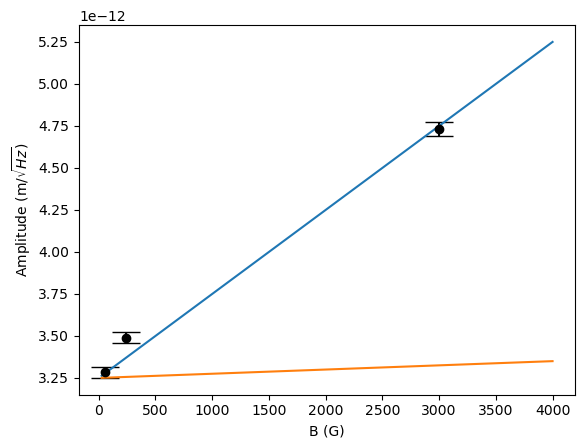

In [220]:
B = [3000, 236, 54]
B2 = 4000*np.linspace(1, (8/100)**2, 1000)

m1 = np.array([amp_mean1, amp_mean2, amp_mean3])
s1 = np.array([amp_std1, amp_std2, amp_std3])

plt.errorbar(B, m1*np.sqrt(10), yerr = s1*np.sqrt(10), color = 'k', marker = 'o', linestyle = 'None', capsize = 10, label = 'Uncorrected')
plt.plot(B2, 0.325*10**(-11)+B2*1*10**(-13)/4000*20, label = 'x20')
plt.plot(B2, 0.325*10**(-11)+B2*1*10**(-13)/4000, label = 'Expected')
plt.xlabel('B (G)')
plt.ylabel('Amplitude (m/$\sqrt{Hz}$)')


In [328]:
def lognormal(x, A, x0, sigma):
    """
    Gaussian function
    x: variable to fit Gaussian to
    A: scaling factor
    x0: mean
    sigma: width of gaussian
    """
    return A*np.exp(-(np.log(x)-x0)**2/(2*sigma**2))

In [378]:
ub = 449

hist, bins = np.histogram(amp_rs*cal3*np.sqrt(10), bins = np.linspace(0, 10*10**(-12), 500))
fit, cov = opt.curve_fit(lognormal, 10**12*(bins[:ub]+bins[1:ub+1])/2, hist[:ub], p0 = [80, 0.5, 0.5])
amplitudes = np.linspace(1e-15, 3*10**(-12), 1000)
fitted = lognormal(amplitudes*10**12, *fit)
"""
hist2, bins2 = np.histogram(amp_rs2*cal3*np.sqrt(10), bins = np.linspace(0, 3*10**(-12), 100))
fit2, cov2 = opt.curve_fit(au.Gaussian, (bins2[:ub]+bins2[1:ub+1])/2, hist2[:ub], p0 = [np.max(hist2), 1.4*10**(-12), 0.5*10**(-12)])
amplitudes2 = np.linspace(0, 3*10**(-12), 1000)
fitted2 = au.Gaussian(amplitudes2, *fit2)

hist3, bins3 = np.histogram(amp_rs3*cal3*np.sqrt(10), bins = np.linspace(0, 3*10**(-12), 100))
fit3, cov3 = opt.curve_fit(au.Gaussian, (bins3[:ub]+bins3[1:ub+1])/2, hist3[:ub], p0 = [np.max(hist3), 1.4*10**(-12), 0.5*10**(-12)])
amplitudes3 = np.linspace(0, 3*10**(-12), 1000)
fitted3 = au.Gaussian(amplitudes3, *fit3)
"""

'\nhist2, bins2 = np.histogram(amp_rs2*cal3*np.sqrt(10), bins = np.linspace(0, 3*10**(-12), 100))\nfit2, cov2 = opt.curve_fit(au.Gaussian, (bins2[:ub]+bins2[1:ub+1])/2, hist2[:ub], p0 = [np.max(hist2), 1.4*10**(-12), 0.5*10**(-12)])\namplitudes2 = np.linspace(0, 3*10**(-12), 1000)\nfitted2 = au.Gaussian(amplitudes2, *fit2)\n\nhist3, bins3 = np.histogram(amp_rs3*cal3*np.sqrt(10), bins = np.linspace(0, 3*10**(-12), 100))\nfit3, cov3 = opt.curve_fit(au.Gaussian, (bins3[:ub]+bins3[1:ub+1])/2, hist3[:ub], p0 = [np.max(hist3), 1.4*10**(-12), 0.5*10**(-12)])\namplitudes3 = np.linspace(0, 3*10**(-12), 1000)\nfitted3 = au.Gaussian(amplitudes3, *fit3)\n'

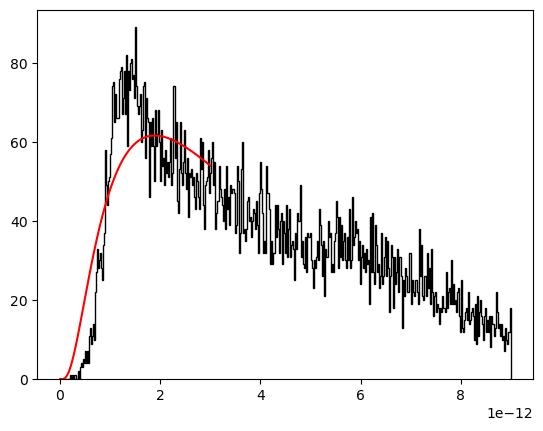

In [380]:
plt.stairs(hist[:ub], bins[:ub+1], label = 'Histogram', color = 'k')
plt.plot(amplitudes, fitted, label = 'Fitted Gaussian', color = 'r')

#plt.stairs(hist2[:ub], bins2[:ub+1], label = 'Histogram', color = 'g')
#plt.plot(amplitudes2, fitted2, label = 'Fitted Gaussian', color = 'b')

#plt.stairs(hist3[:ub], bins3[:ub+1], label = 'Histogram', color = 'gray')
#plt.plot(amplitudes3, fitted3, label = 'Fitted Gaussian', color = 'orange')

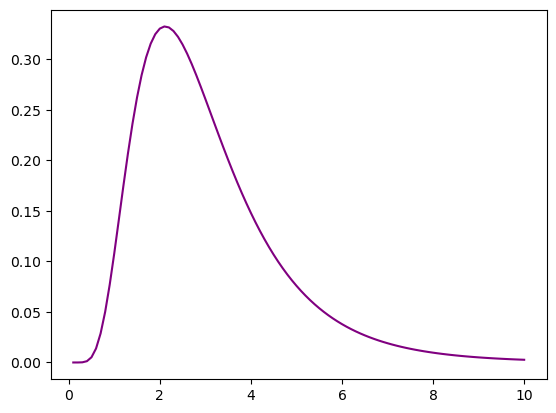

In [324]:
x = np.linspace(0.1, 10, 100)
sig = 0.5
u = 1

plt.plot(x, 1/x/sig/np.sqrt(2*np.pi)*np.exp(-(np.log(x)-u)**2/(2*sig**2)), label = '1/x Gaussian', color = 'purple')

<ErrorbarContainer object of 3 artists>

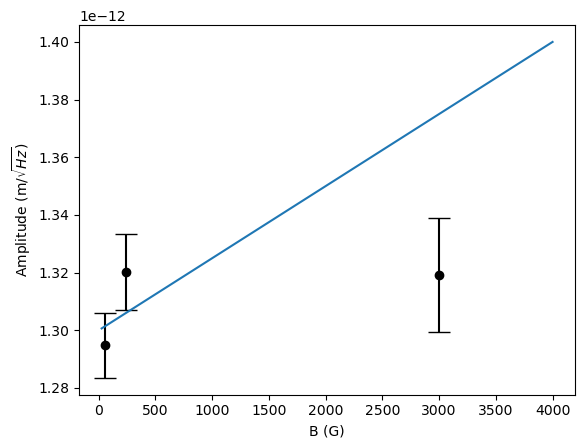

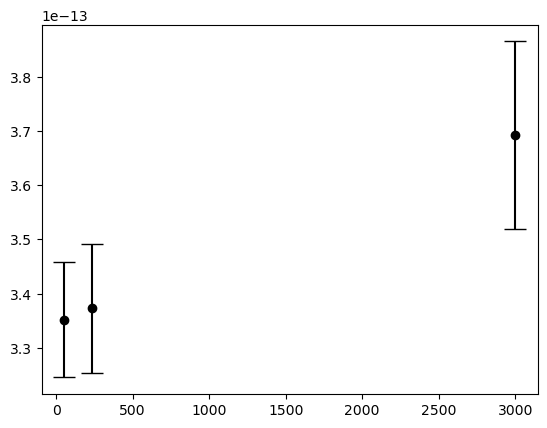

In [323]:
plt.errorbar(B, [fit[1], fit2[1], fit3[1]], yerr = [np.sqrt(cov[1][1]), np.sqrt(cov2[1][1]), np.sqrt(cov3[1][1])], marker = 'o', linestyle = 'None', color = 'k', capsize = 8, label = 'Fitted mean')
plt.plot(B2, 0.130*10**(-11)+B2*1*10**(-13)/4000, label = 'Expected')
plt.xlabel('B (G)')
plt.ylabel('Amplitude (m/$\sqrt{Hz}$)')
plt.figure()
plt.errorbar(B, [fit[2], fit2[2], fit3[2]], yerr = [np.sqrt(cov[2][2]), np.sqrt(cov2[2][2]), np.sqrt(cov3[2][2])],marker = 'o', linestyle = 'None', color = 'k', capsize = 8,label = 'Fitted std')

(0.0, 1.5095932799115383e-12)

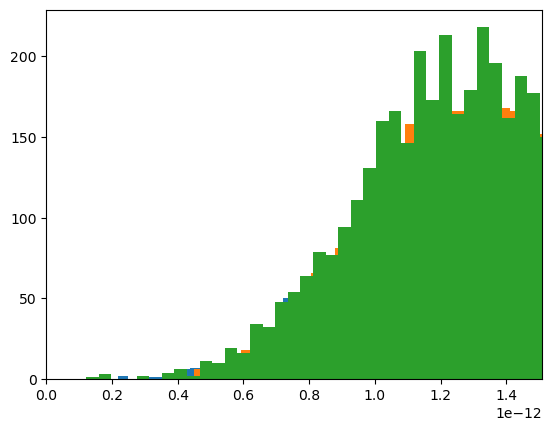

In [242]:
lb = 0
ub = 20000
plt.hist(amp_rs[lb:ub]*cal3*np.sqrt(10), bins = 1000)
plt.hist(amp_rs2[lb:ub]*cal3*np.sqrt(10), bins = 1000)
plt.hist(amp_rs3[lb:ub]*cal3*np.sqrt(10), bins = 1000)
plt.xlim(0, 0.0015*cal3*np.sqrt(10))

In [90]:
phase_rs = phases_pos[:,:, 0, 0].reshape((20000))
phase_rs2 = phases_pos[:,:, 1, 0].reshape((20000))
phase_rs3 = phases_pos[:,:, 2, 0].reshape((20000))

In [93]:
lb = 0
ub = 5000
pm1 = np.mean(phase_rs[lb:ub])
pm2 = np.mean(phase_rs2[lb:ub])
pm3 = np.mean(phase_rs3[lb:ub])

std1 = np.std(phase_rs[lb:ub])/np.sqrt(len(phase_rs[lb:ub]))
std2 = np.std(phase_rs2[lb:ub])/np.sqrt(len(phase_rs2[lb:ub]))  
std3 = np.std(phase_rs3[lb:ub])/np.sqrt(len(phase_rs3[lb:ub]))
print(np.mean(phase_rs[lb:ub]), np.std(phase_rs[lb:ub])/np.sqrt(len(phase_rs[lb:ub])))
print(np.mean(phase_rs2[lb:ub]), np.std(phase_rs2[lb:ub])/np.sqrt(len(phase_rs2[lb:ub])))
print(np.mean(phase_rs3[lb:ub]), np.std(phase_rs3[lb:ub])/np.sqrt(len(phase_rs3[lb:ub])))

-3.617083782915512 0.02811302859478076
-3.319803225990571 0.03079019392704535
-3.2976372731136783 0.031900255857961156


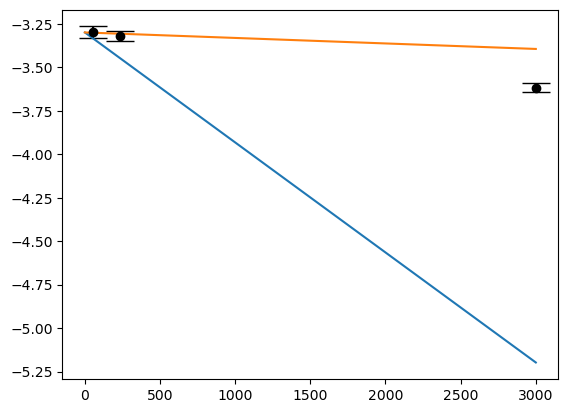

In [105]:
plt.errorbar(B, [pm1, pm2, pm3], yerr = [std1, std2, std3], marker = 'o', linestyle = 'None', color = 'k', capsize = 10, label = 'Phase')
plt.plot([0, 3000], [-3.3, -3.3-0.3/np.sqrt(10)*20])
plt.plot([0, 3000], [-3.3, -3.3-0.3/np.sqrt(10)])

In [115]:
np.mean(amps_pos[-1, -1, 1, 0]*cal3)

7.127082403266994e-12

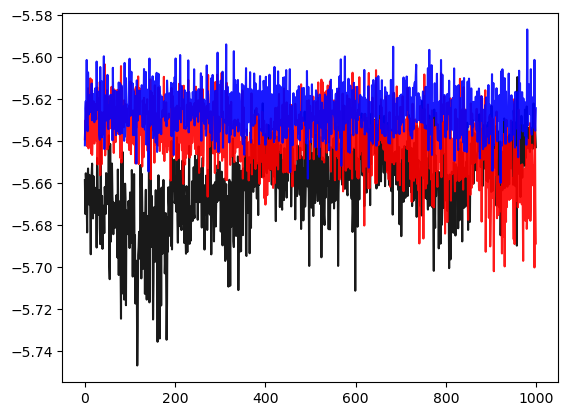

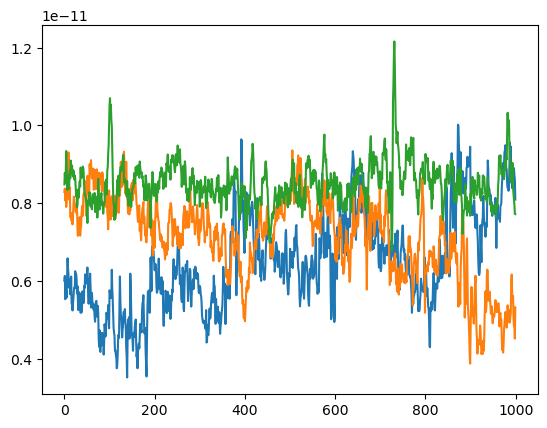

In [122]:
plt.plot(phases_pos[4, 1, 0, 0, :], 'k', alpha = 0.9)
plt.plot(phases_pos[-1, -1, 1, 0, :], 'r', alpha = 0.9)
plt.plot(phases_pos[-1, -1, 2, 0, :], 'b', alpha = 0.9)
plt.figure()
plt.plot(amps_pos[4, 1, 0, 0]*cal3)
plt.plot(amps_pos[-1, -1, 1, 0]*cal3)
plt.plot(amps_pos[-1, -1, 2, 0]*cal3)

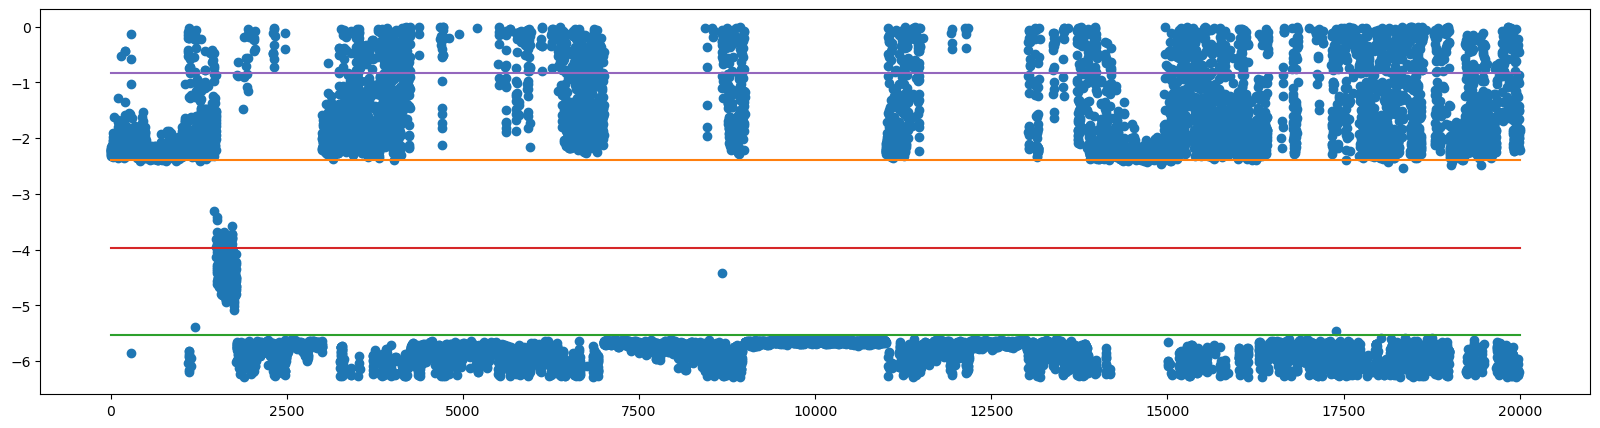

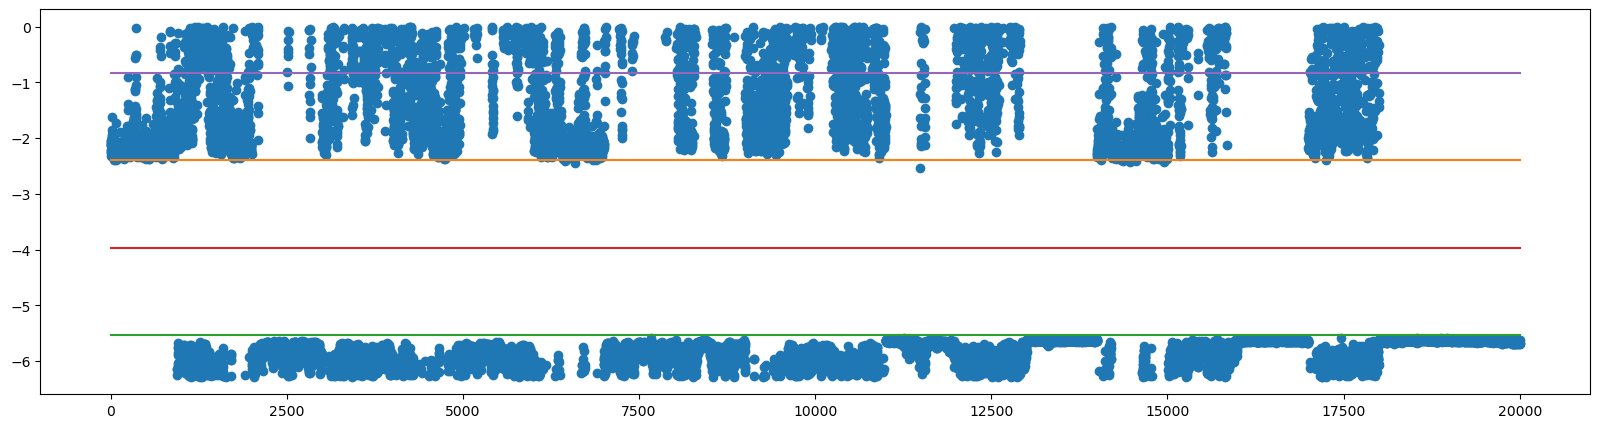

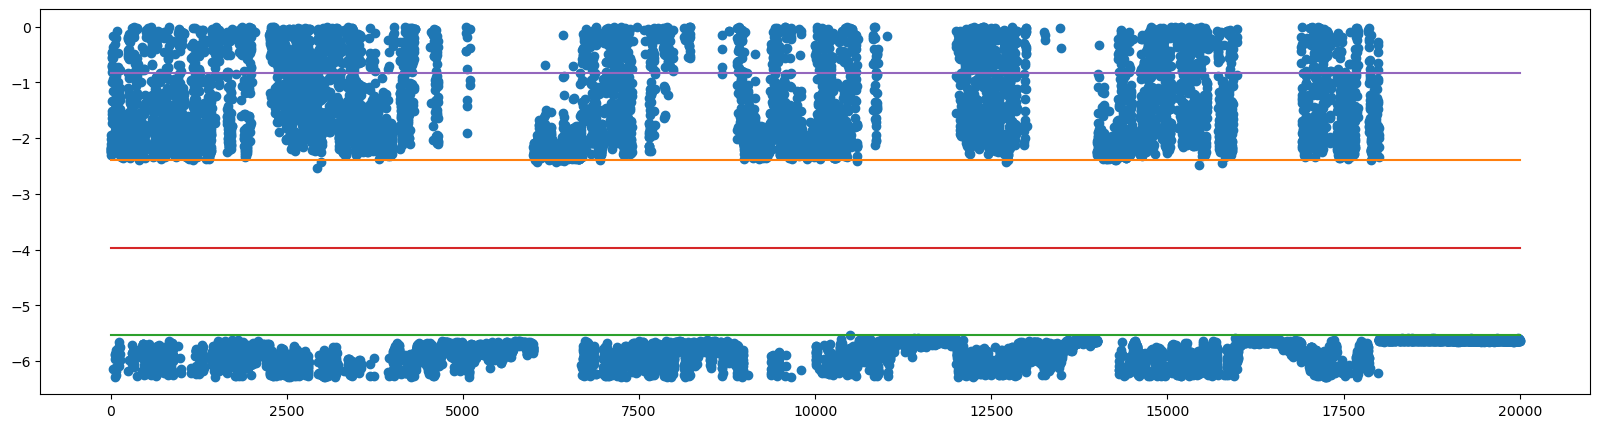

In [133]:
plt.figure(figsize = (20, 5))
plt.plot(phase_rs, 'o')
plt.plot([0, 20000], [-2.4, -2.4])

plt.plot([0, 20000], [-2.4-np.pi, -2.4-np.pi])
plt.plot([0, 20000], [-2.4-np.pi/2, -2.4-np.pi/2])

plt.plot([0, 20000], [-2.4+np.pi/2, -2.4+np.pi/2])
plt.figure(figsize = (20, 5))
plt.plot(phase_rs2, 'o')
plt.plot([0, 20000], [-2.4, -2.4])

plt.plot([0, 20000], [-2.4-np.pi, -2.4-np.pi])
plt.plot([0, 20000], [-2.4-np.pi/2, -2.4-np.pi/2])

plt.plot([0, 20000], [-2.4+np.pi/2, -2.4+np.pi/2])
plt.figure(figsize = (20, 5))
plt.plot(phase_rs3, 'o')
plt.plot([0, 20000], [-2.4, -2.4])

plt.plot([0, 20000], [-2.4-np.pi, -2.4-np.pi])
plt.plot([0, 20000], [-2.4-np.pi/2, -2.4-np.pi/2])

plt.plot([0, 20000], [-2.4+np.pi/2, -2.4+np.pi/2])

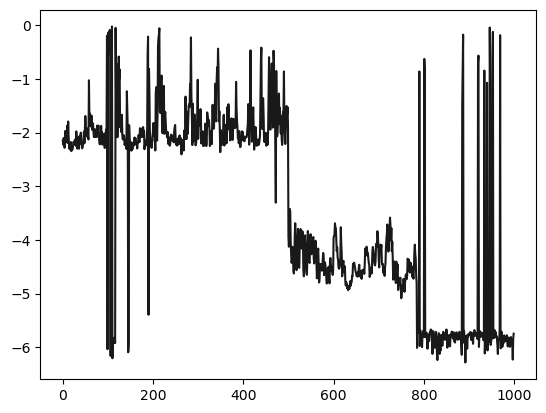

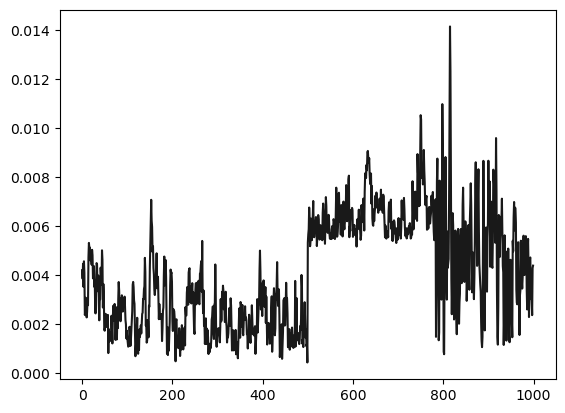

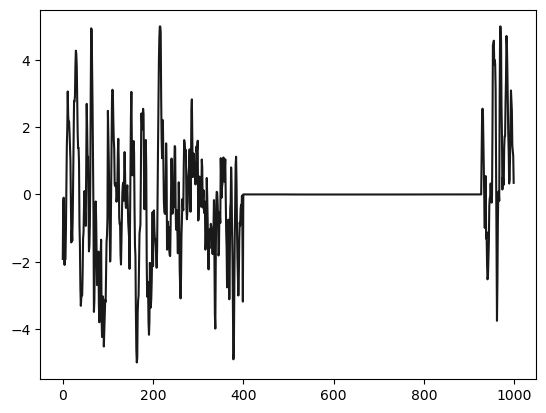

In [171]:
plt.plot(phases_pos[0, 1, 0, 0, :], 'k', alpha = 0.9)
plt.figure()
plt.plot(amps_pos[0, 1, 0, 0, :], 'k', alpha = 0.9)
plt.figure()
plt.plot(lockin_pos[0, 1, 0, :], 'k', alpha = 0.9)

In [201]:
freqs = [5500]
numfiles = 10
int_n = 10**5
file_n = 10**7
samples_per_file = int(file_n/int_n)

cycle = 0
direction = 1
position = 0

path = r'D:\Lab Data\lorentz_force\sphere20250604\20250609\1 V\pos'+str(position)+' '+str(direction)+str(cycle)+r'\tt'
file = 8
end = '.hdf5'
    
filename = path + str(file) + end
data, attrs = au.load_data_lf(filename)
drive = data['channel_f'][:]
drive2 = data['channel_d'][:]
lockin = data['channel_g'][:]
                  
PSD_D = scisig.welch(drive2, fs = 1/attrs['delta_t'], nperseg = int(1/attrs['delta_t']))

path = r'D:\Lab Data\lorentz_force\sphere20250604\20250609\1 V\pos'+str(position)+' '+str(direction)+str(cycle)+r'\tt'
file = 0
end = '.hdf5'
    
filename = path + str(file) + end
data, attrs = au.load_data_lf(filename)
drive_2 = data['channel_f'][:]
drive2_2 = data['channel_d'][:]
lockin = data['channel_g'][:]
                  
PSD_D2 = scisig.welch(drive2, fs = 1/attrs['delta_t'], nperseg = int(1/attrs['delta_t']))

In [202]:
def lockin_ext_signal(data, ext_sig, phase, fs, demod_freq, BW_pre, BW, BW2, mode):
    time = np.array(range(len(data)))/fs
    if phase == 0:
        demod = ext_sig
        esfft = np.fft.rfft(ext_sig)
        esfft_phaseshift = np.exp(np.pi/2*1j)*esfft
        demod2 = np.fft.irfft(esfft_phaseshift)
    else:
        esfft = np.fft.rfft(ext_sig)
        esfft_phaseshift = np.exp((phase)*1j)*esfft
        demod = np.fft.irfft(esfft_phaseshift)
        esfft_phaseshift = np.exp((np.pi/2+phase)*1j)*esfft
        demod2 = np.fft.irfft(esfft_phaseshift)
    if BW_pre != 0:
            data = au.butter_bandpass_filter(data, demod_freq - BW_pre, demod_freq + BW_pre, fs, order = 3)
    X_tt = data*demod
    Y_tt = data*demod2
    X_tt_filt = au.butter_lowpass_filter(X_tt, BW, fs, order = 3)
    Y_tt_filt = au.butter_lowpass_filter(Y_tt, BW, fs, order = 3)
    if mode == 'XY':
        return time, X_tt_filt, Y_tt_filt
    elif mode == 'R':
        R2 = X_tt_filt**2 + Y_tt_filt**2
        theta = np.unwrap(-2*np.arctan(X_tt_filt[1:]/Y_tt_filt[1:]))/2
        R2_filt = au.butter_lowpass_filter(R2, BW2, fs, order = 2)
        theta_filt = au.butter_lowpass_filter(theta, BW2, fs, order = 2)
        return time, R2, theta, R2_filt, theta_filt
    else:
        return 0

In [203]:
d_filt = au.butter_bandpass_filter(drive2, 54999, 55001, fs = 1/attrs['delta_t'], order = 2)
d_filt2 = au.butter_bandpass_filter(drive2_2, 54999, 55001, fs = 1/attrs['delta_t'], order = 2)

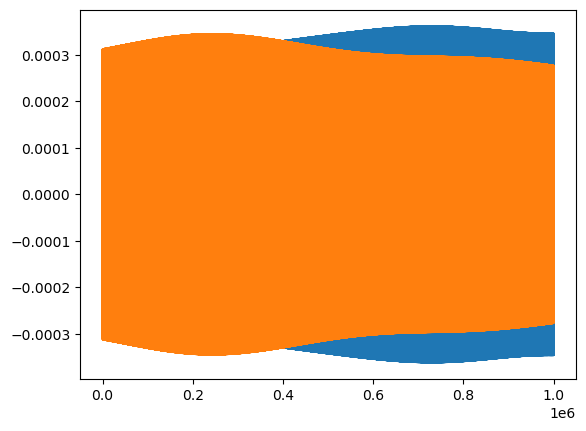

In [204]:
plt.plot(d_filt[10**6:2*10**6])
plt.plot(d_filt2[10**6:2*10**6])

In [205]:
time, X, Y = lockin_ext_signal(d_filt, drive, phase = -0.9, fs = 1/attrs['delta_t'], demod_freq = 55000, BW_pre = 0, BW = 10, BW2 = 10, mode = 'XY')
time, X2, Y2 = lockin_ext_signal(d_filt2, drive_2, phase = -0.9, fs = 1/attrs['delta_t'], demod_freq = 55000, BW_pre = 0, BW = 10, BW2 = 10, mode = 'XY')

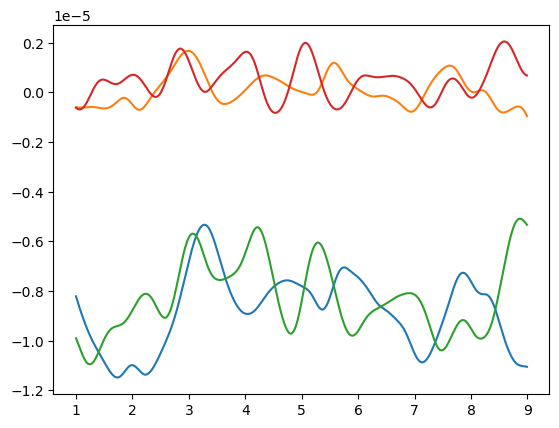

In [206]:
lb = 10**6
ub = 9*10**6
s = 10**4

plt.plot(time[lb:ub:s], X[lb:ub:s])
plt.plot(time[lb:ub:s], Y[lb:ub:s])

plt.plot(time[lb:ub:s], X2[lb:ub:s])
plt.plot(time[lb:ub:s], Y2[lb:ub:s])

In [207]:
time, R2, theta, R2_filt, theta_filt = lockin_ext_signal(d_filt, drive, phase = -0.9, fs = 1/attrs['delta_t'], demod_freq = 55000, BW_pre = 0, BW = 10, BW2 = 10, mode = 'R')
time, R22, theta2, R2_filt, theta_filt = lockin_ext_signal(d_filt2, drive_2, phase = -0.9, fs = 1/attrs['delta_t'], demod_freq = 55000, BW_pre = 0, BW = 10, BW2 = 10, mode = 'R')

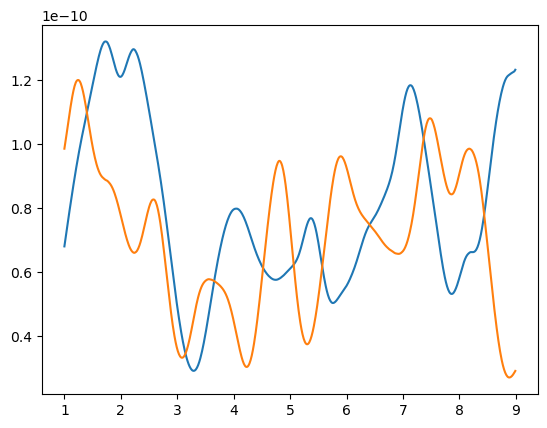

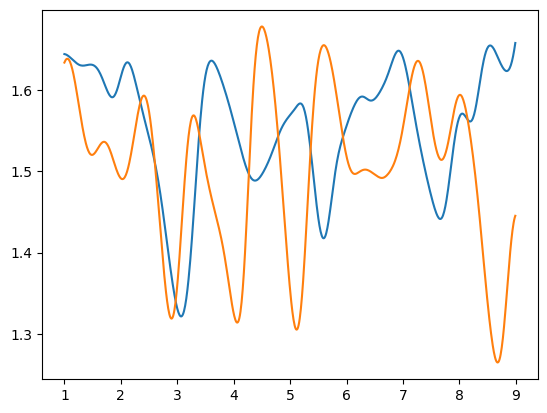

In [208]:
plt.plot(time[lb:ub:s], R2[lb:ub:s])
plt.plot(time[lb:ub:s], R22[lb:ub:s])
plt.figure()
plt.plot(time[lb:ub:s], theta[lb:ub:s])
plt.plot(time[lb:ub:s], theta2[lb:ub:s])